# <span style="color:orangered">  Riccardo Beccaria - Random Walk

In [1]:
# multidimensional arrays
import numpy as np
from tqdm import tqdm

# inline plots
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# nicer figures
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Return to the origin


For a *finite* random walk of (large) length $n$, it is known that the expected number of returns to the origin $T_n$ scales like follows:
$$
\left\langle T_n \right\rangle \sim \left\{
\begin{array}{ll}
\sqrt{n} & d=1 \\
\log(n) & d=2 \\
C_d & d\geq 3
\end{array}
\right.
$$



Notice that for $d \geq 3$, $\left\langle T_n \right\rangle$ does **not** grow with $n$, which must mean that the walker somehow "escapes" and never returns back to the origin. The probability of return to the origin is less than 1! For an infinite-length random walk, indeed the probability of returning to the origin $\rho$ is seen to be

$$
\rho \sim \left\{
\begin{array}{ll}
1 & d=1 \\
1 & d=2 \\
<1 & d\geq 3
\end{array}
\right.
$$

The *intuitive* explanation of this amazing fact is that, as the dimension $d$ grows, there are "more directions available", and so more chances for the walker to "get lost" and never return to the origin. There is of course a formal proof as well, but today we will do a **computational verification** of these facts, which is no substitute for a formal proof but is often all we can do!

## Generating Random Walks


### Exercise 3.1
Write a function that generates a random walk of given length in $d$ dimensions. Your random walker should move as follows:

+ At each time-step, the walker moves only in one direction.
+ At each time-step, the walker moves only by -1 or +1

Your function should return a numpy array of shape (`length`, `dim`). Example:
```python
>>> # create a RW of length 10 in dimension 3
>>> traj = get_traj(length=10, dim=3)
>>> # check that the output has the right shape
>>> traj.shape
(10, 3)
```

In [2]:
%%time

def get_traj(length, dim):
    
    steps= length
    pos=np.zeros((length,dim))
    dir_array=np.random.randint(dim, size=steps)
    updown_array=np.random.uniform(0,1,size=steps)
    
    for i in range(steps):
        dir=dir_array[i]
        updown=updown_array[i]
        pos[i,:]=pos[i-1,:]
        if updown<0.5:
            pos[i,dir]+=1
        else:
            pos[i,dir]+=-1
            
    return pos

traj = get_traj(3,2)

CPU times: user 258 µs, sys: 113 µs, total: 371 µs
Wall time: 326 µs


### Verification
To make sure that your function works correctly, execute the following cell. Notice the use of `assert` statements: execution should fail if something goes wrong. If everything is fine, nothing should happen.

In [3]:
# basic checks for your RW generator
for dim in range(1, 5):
    for length in [10, 100, 200, 500]:
        traj = get_traj(length, dim)
        # make sure traj has the right shape
        assert traj.shape == (length, dim)
        # make sure all steps are -1 or 1 in only one direction
        assert np.all(np.sum(np.diff(traj, axis=0) != 0, axis=1) == np.ones(length - 1))

### Exercise 3.2
Plot a random walk of length $10^4$ for $d=1$ (time in x-axis, position in y-axis) and $d=2$ (x,y components in x,y-axis). Remember to use **axis labels**.

In [4]:
# it is better if you use one cell to generate the random walks, and a second cell to plot them
lenght=10**4

RW_1d = get_traj(lenght,1)
RW_2d = get_traj(lenght,2)
RW_3d = get_traj(lenght,3)

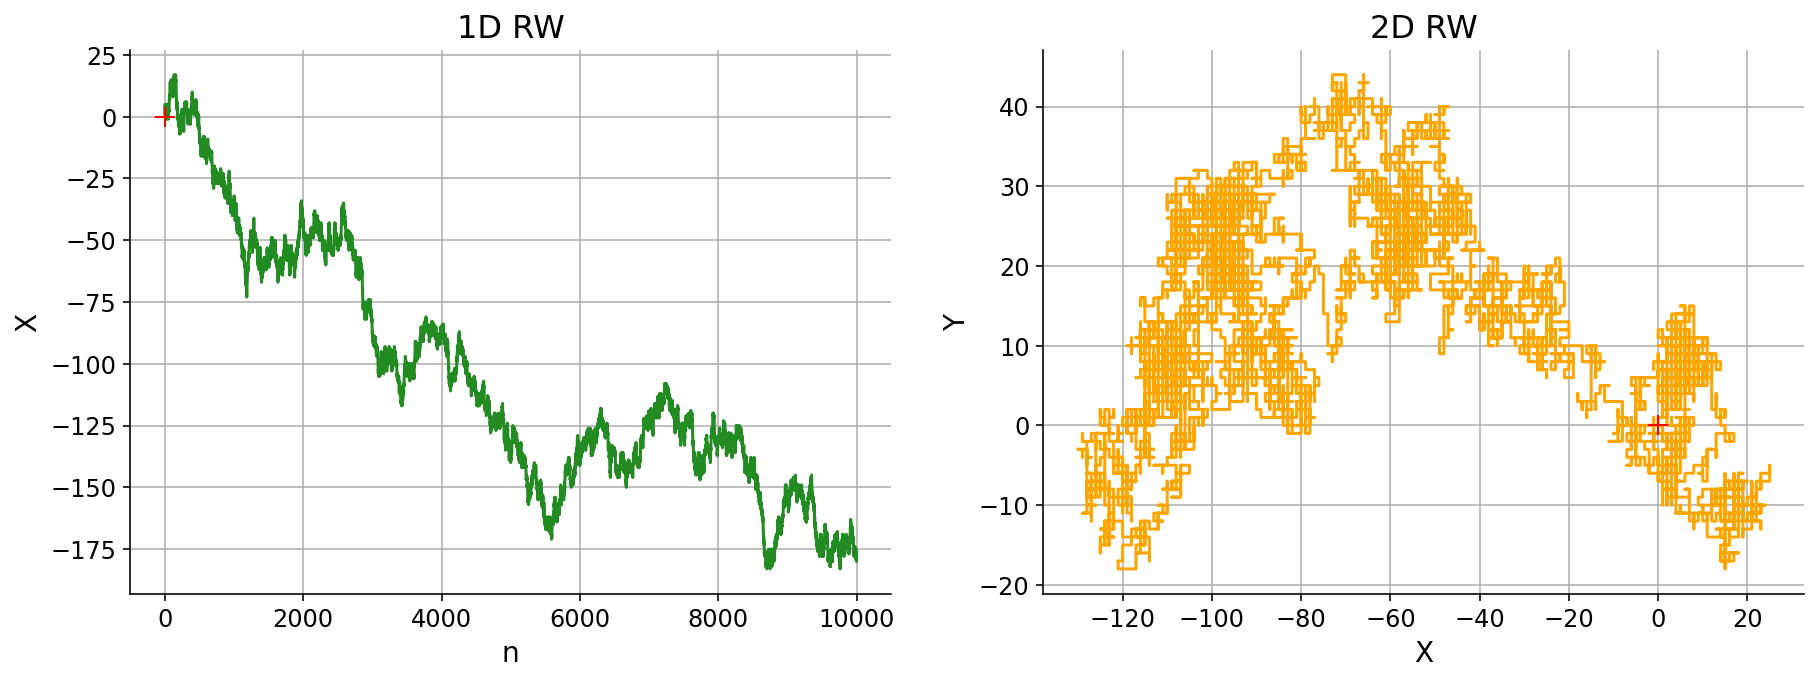

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(RW_1d, c='forestgreen')
axs[1].plot(RW_2d[:,0], RW_2d[:,1],c='orange')

axs[0].set_title("1D RW")
axs[0].set_xlabel("n")
axs[0].set_ylabel("X")
axs[1].set_title("2D RW")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")

for ax in axs.flatten():
    ax.grid()
    ax.plot(0, 0, c='red', marker='+',markersize=10)


Text(0.5, 0, 'Z')

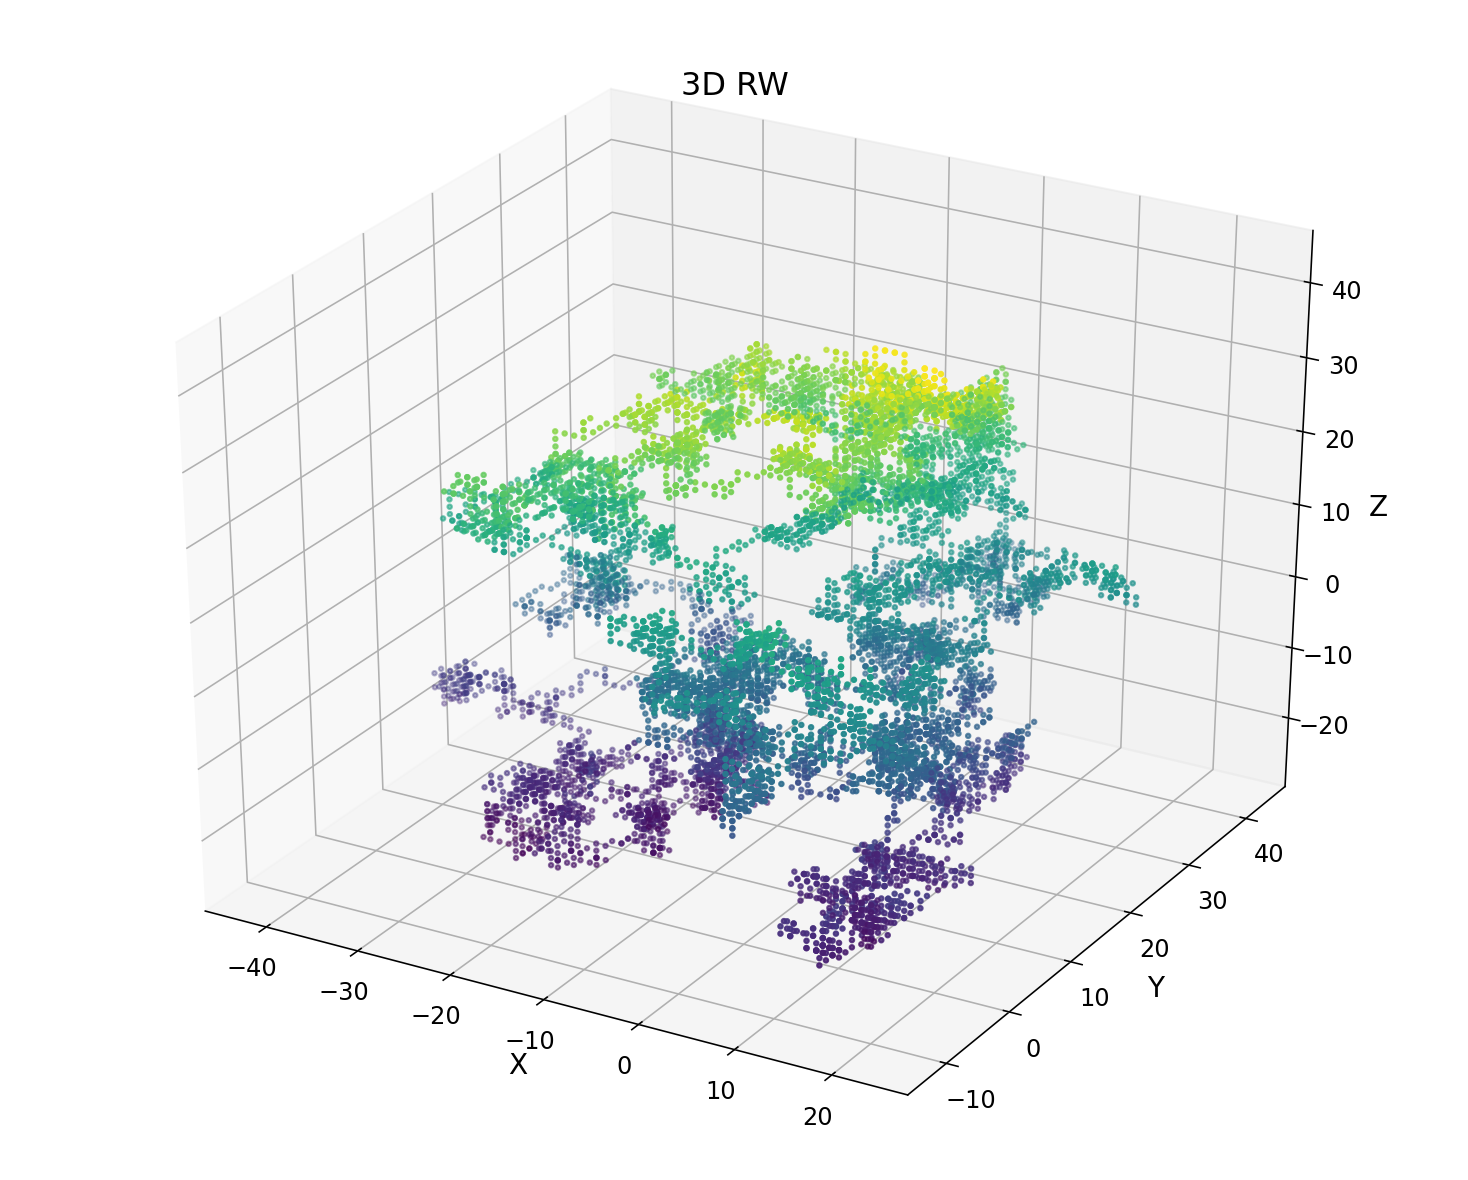

In [6]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

fig = plt.figure(figsize=(10,8))
ax = p3.Axes3D(fig)
X,Y,Z=RW_3d[:,0],RW_3d[:,1],RW_3d[:,2]
ax.scatter(X,Y,Z, c=Z, marker=".")
ax.set_title("3D RW")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

## Counting the number of returns to the origin
Since we are interested in how **the expected number of returns to the origin** scales with the RW length, we don't need to store the whole trajectory of each simulation (we will be performing many simulations!). 

### Exercise 3.3
Write a function that generates a RW of given length and dimension (calling `get_traj`), and returns the number of times it returned to the origin. To count the number of returns to the origin, you might need to use the following functions:
```python
np.all()
np.zeros()
```

In [7]:
def get_num_return(lenght, dim):
    num_returns_to_origin = 0
    traj = get_traj(lenght, dim)
    for i in range(lenght):
        Check = True
        for j in range(dim):
            if traj[i][j] != 0:
                Check = False
        if Check == True:
            num_returns_to_origin += 1
    return num_returns_to_origin

I've built a function that counts the numbers of return to the origin of the RW. In order to do that, I've done two for loops. The first loop is over the legth, to check all the points in the trajectory. The second loop is over the dimension of the RW because, to increase the number of return, I need that ALL the coordinates of the walk are equal to zero!

### Exercise 3.4
Write a function that computes the expected number of returns to the origin for a given length and dimension. Your function will call `get_num_returns()`, and should have an additional parameter that sets the sample size.

In [8]:
def get_average_num_returns(length, dim, num_trajs):
    ave = 0
    for i in range(num_trajs):
        ave += get_num_return(length, dim)
    return ave/(num_trajs)

## Comparing with analytical results
We are now ready to compare our analytical results with numerical simulations! We want to plot the expected number of returns to the origin as a function of the RW length. To do this, it is useful to first define an array of RW lengths.

In [9]:
# define range of RW lengths
length_min = 10
length_max = 100000
# generate points logarithmically spaces
# and convert them to integers
length_array = np.array([
    int(x)
    for x in np.geomspace(length_min, length_max, num=20)
])

(tip: if your RW generating function is not very efficient, you might want to decrease `length_min`)  

Executing the following cell will run all simulations for $d=1$


In [10]:
dim=1
num_returns_array = np.array([
    get_average_num_returns(length, dim, 200)
    for length in tqdm(length_array)
])

100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


### Exercise 3.5
Plot the average number of returns to the origin of a 1D RW as a function of the RW length, together with the expected theoretical result. Do your results verify the $n^{1/2}$ scaling? **Tip** Use double-logarithmic scales in your plot. Remember to include label axis, and a legend!

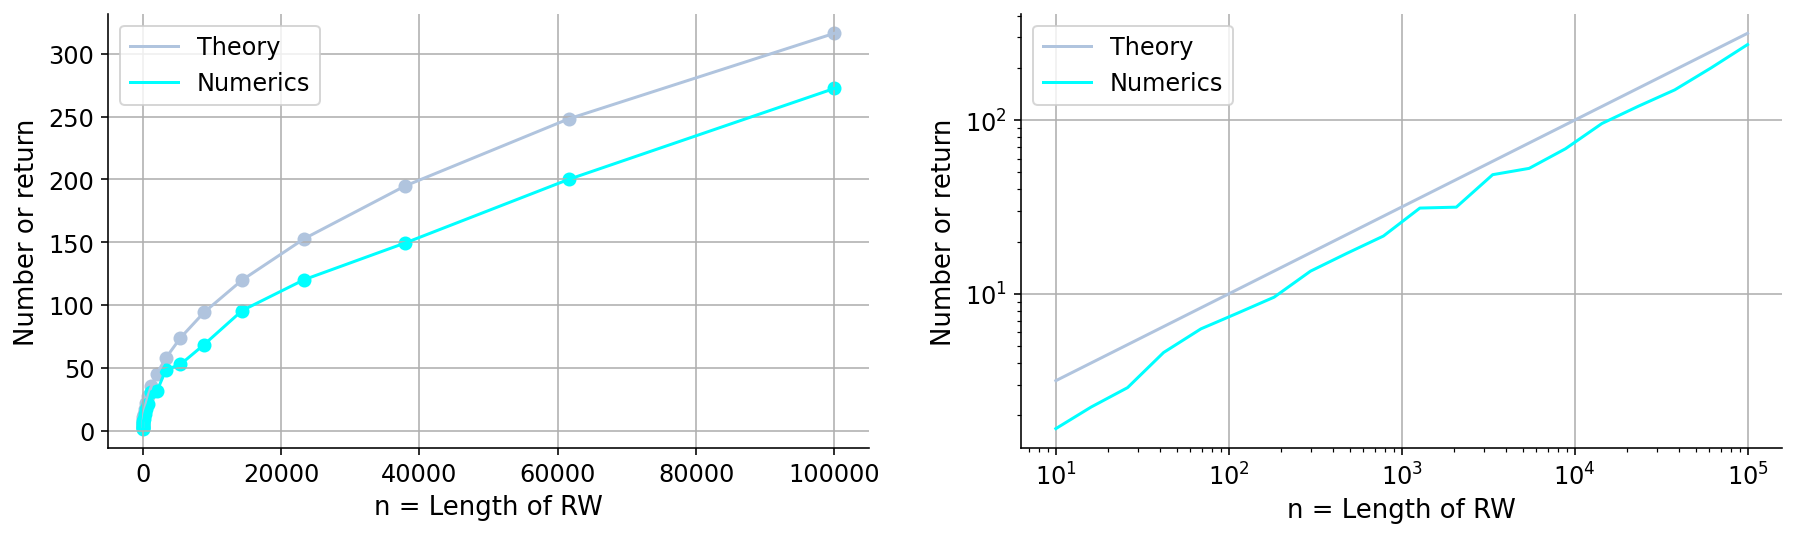

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(length_array,np.sqrt(length_array),label='Theory',c='lightsteelblue')
ax[0].plot(length_array, num_returns_array, label="Numerics", color='aqua')
ax[0].scatter(length_array,np.sqrt(length_array),c='lightsteelblue')
ax[0].scatter(length_array, num_returns_array, color='aqua')
ax[1].loglog(length_array, np.sqrt(length_array), label="Theory",c='lightsteelblue')
ax[1].loglog(length_array, num_returns_array, label="Numerics",color='aqua')

for ax in ax.flat:
    ax.grid()
    ax.set_xlabel(r'n = Length of RW', fontsize=13)
    ax.set_ylabel(r'Number or return', fontsize=13)
    ax.grid(True)
    ax.legend()

These plots show a perfect agreement between theory and numerical results. In the right plot, where I've drawn Theory result and numerical results in log-log scale, you can see the same trend of the two dataset: parallel straight lines with angular coefficient $m=\frac{1}{2}$, that clarify the $n^\frac{1}{2}$ trend of the Random Walk in one dimension.

### Exercise 3.6
Plot the average number of returns to the origin of a 2D RW as a function of the RW length. Do your results verify the $log(n)$ scaling? What are the best axis scales to use in this case?

In [12]:
# do the simulations for d=2
dim=2
num_returns_array = np.array([
    get_average_num_returns(length, dim, 200)
    for length in tqdm(length_array)
])

100%|██████████| 20/20 [02:00<00:00,  6.03s/it]


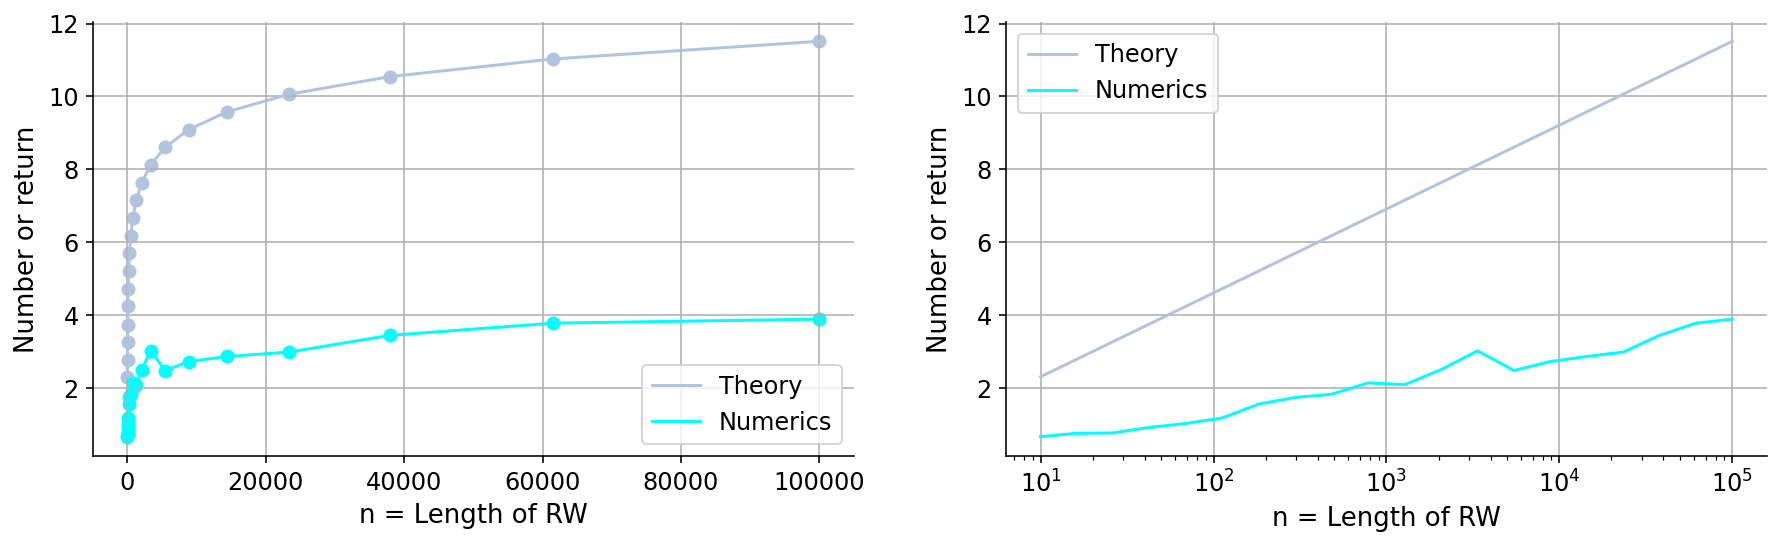

In [13]:
# plot the numerical results + theory
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(length_array,np.log(length_array),label='Theory',c='lightsteelblue')
ax[0].plot(length_array, num_returns_array, label="Numerics", color='aqua')
ax[0].scatter(length_array,np.log(length_array),c='lightsteelblue')
ax[0].scatter(length_array, num_returns_array, color='aqua')
ax[1].plot(length_array, np.log(length_array), label="Theory",c='lightsteelblue')
ax[1].plot(length_array, num_returns_array, label="Numerics",color='aqua')
ax[1].set_xscale('log')

for ax in ax.flat:
    ax.grid()
    ax.set_xlabel(r'n = Length of RW', fontsize=13)
    ax.set_ylabel(r'Number or return', fontsize=13)
    ax.grid(True)
    ax.legend()

In these plots I've shown the trend of the number of return in function of lenth of 2D Random Walks. I expect a logarithmic trend. That's why, in the right plot, I've shown the numerical and theory results with x axis in log scale. Getting two straight lines in x log scale, prove the $\log n$ trend of the return to the origin for 2D Random Walks.

### Exercise 3.7
Show numerically that, for $d=3$ and $d=4$, the expected number of returns to the origin is **constant**.

In [14]:
# do the simulations for d=2
dim=3
num_returns_array_3 = np.array([
    get_average_num_returns(length, dim, 200)
    for length in tqdm(length_array)
])

dim=4
num_returns_array_4 = np.array([
    get_average_num_returns(length, dim, 200)
    for length in tqdm(length_array)
])

100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


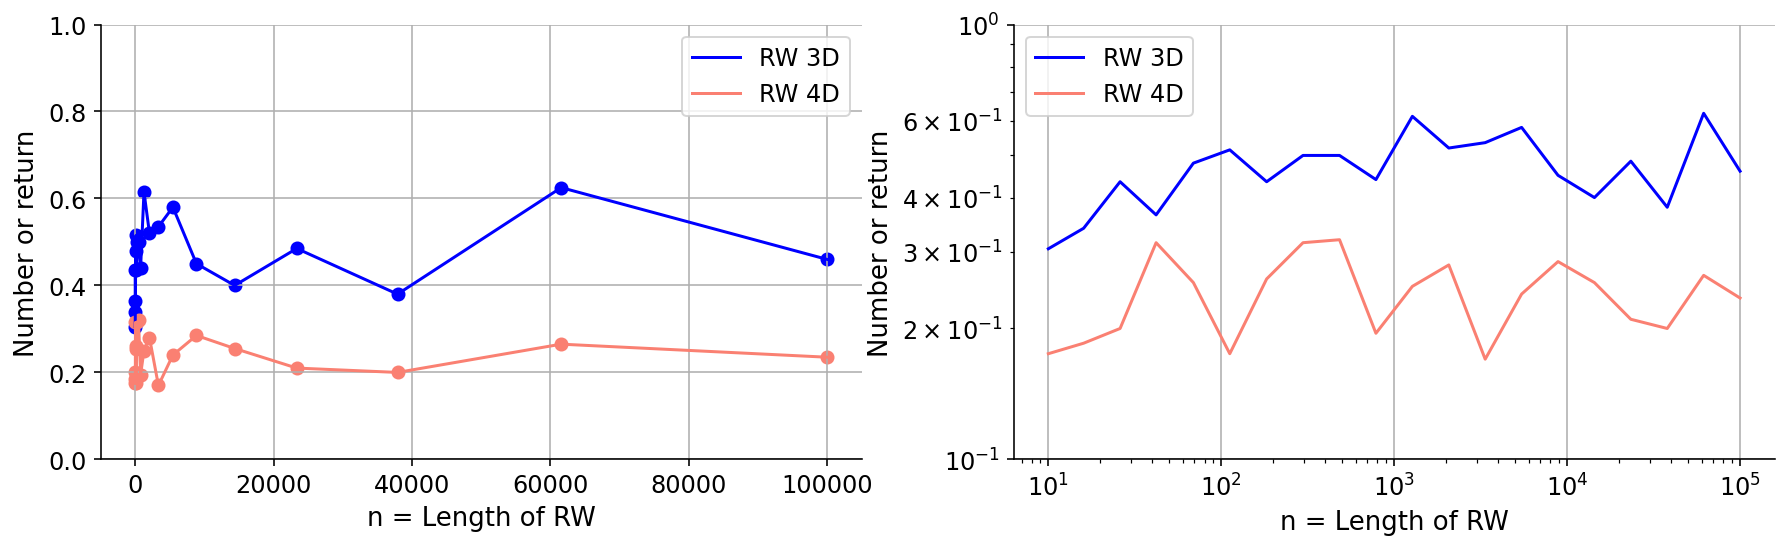

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(length_array, num_returns_array_3, label="RW 3D", color='blue')
ax[0].plot(length_array, num_returns_array_4, label="RW 4D", color='salmon')
ax[0].scatter(length_array, num_returns_array_3, color='blue')
ax[0].scatter(length_array, num_returns_array_4, color='salmon')
ax[0].set_ylim(0,1)

ax[1].loglog(length_array, num_returns_array_3, label="RW 3D",color='blue')
ax[1].loglog(length_array, num_returns_array_4, label="RW 4D",color='salmon')
ax[1].set_ylim(0.1,1)

for ax in ax.flat:
    ax.grid()
    ax.set_xlabel(r'n = Length of RW', fontsize=13)
    ax.set_ylabel(r'Number or return', fontsize=13)
    ax.grid(True)
    ax.legend()

These two graphics show that the number of return for 3D Random Walks and 4D Random Walks are constant with the lenght of the trajectory.

# Self-Avoiding Walks
Self-avoiding walks (SAW) are simply random walks in a regular lattice with the additional constraint that no point can be visited more than once. That is, SAWs cannot intersect themselves. The most well-known application of SAW is to model linear polymers, where obviously two monomers cannot occupy the same space (excluded volume effect).


You can read more about self-avoiding walks in this nice introduction by Gordon Slade:

[Self-Avoiding Walks, by Gordon Slade](https://www.math.ubc.ca/~slade/intelligencer.pdf)

## Simulating Self-Avoiding Walks
Generating a SAW is not trivial. If you try to generate a SAW stochastically, that is, one step at a time, you will miserably fail: your walker might get into traps (configurations with no allowed movements), and if it does you will have to discard your simulation. It turns out you will have to discard your simulation *really* often, so that for large lengths, you will basically never find a valid path. In addition, the paths you will find for short lengths will not come up with the right probabilities. Bear in mind that we want to **uniformly sample** the set of SAW of given length $n$, SAW($n$). That is, we want that all paths from SAW($n$) are generated with the same probability.

The solution is to use a Monte Carlo algorithm that, given one element $\alpha \in \text{SAW}(n)$, generates a new one $\beta \in \text{SAW}(n)$ with some probability $P_{\alpha \beta}$. If in addition our algorithm satisfies **detailed balance** and is **ergodic**, then we known that it will converge to the equilibrium distribution (the uniform distribution in our case).


## The pivot algorithm
We will implement the pivot algorithm, which is simple, effective, and satisfies detailed balance and ergodicity. You can read about the details of the pivot algorithm here:

[The Pivot Algorithm: A Highly Efficient Monte Carlo Method for the Self-Avoiding Walk](https://link.springer.com/article/10.1007/BF01022990)

(tip: if you're at home, **do not** use tools such as sci-hub to download the paper).

Given a self-avoiding walk of length $n$, the pivot algorithm generates the next walk $\beta \in \text{SAW}(n)$ as follows:

1. **Choose a point of $\alpha$ at random**, splitting the path in two bits: the head (from the origin to the chosen point) and the tail (from the chosen point to the end of the path). Notice that both the head and the tail are SAWs.
2. **Apply a transformation to the tail**, leaving the head intact. The transformation must be an orthoganl transformation that leaves the regular lattice intact (so, either a reflection or a $90º, 180º$ or $270º$ rotation). For simplicity, we will use only **rotations** (read the paper to see why this is ok).
3. **Check if the new path is self-avoiding**. If so, return it. Otherwise, return the original path.

Iterating these steps one obtains a **Markov** chain of SAWs: $\alpha_1 \to \alpha_2 \to \dots \to \alpha_M $. Notice that $\alpha_i$ are not uncorrelated, but because the algorithm satisfies detailed balance and is ergodic, we know that it approaches the equilibrium distribution. This means that we can use our Markov chain to compute **expected values** as long as it is long enough.

## Implementing the pivot step in 2D
To implement the **pivot algorithm** in 2D, we will write one function that does steps 1 and 2, and another function that does step 3. We will also need a function to generate standard 2D random walks.

### Exercise 3.8
Write a function `get_traj` that generates a 2D random walk of given length.

In [16]:
def get_traj(length):
    """Generate a 2D random walk of given length"""
    steps= length
    pos=np.zeros((length+1,2))
    dir_array=np.random.randint(2, size=steps+1)
    updown_array=np.random.uniform(0,1,size=steps+1)
    
    for i in range(1,steps+1):
        dir=dir_array[i]
        updown=updown_array[i]
        pos[i,:]=pos[i-1,:]
        if updown<0.5:
            pos[i,dir]+=1
        else:
            pos[i,dir]+=-1
            
    return pos

### Exercise 3.9
Write a function `pivot_traj` that, given a 2D random walk, performs steps 1 and 2 of the pivot algorithm. Some useful functions:
```python
np.random.randint()
np.concatenate()
```
You might also want to multiply matrices using the `@` operator:
```python
>>> a = np.array([[1, 2], [3, 4], [5, 6]])
>>> b = np.array([1, 1])
>>> a @ b
array([ 3,  7, 11])
```


In [17]:
def pivot_traj(traj):
    """Apply a random rotation to part of a RW."""
    
    # choose the pivot
    pivot_index = np.random.randint(1,len(traj))
    pivot_point = traj[pivot_index]

    # split head and tail
    traj_head = traj[:pivot_index]
    traj_tail = traj[pivot_index:]
    
    traj_tail = traj_tail - pivot_point
    
    # define the rotation matrices
    symmetries = [
        # 90 deg rotation
        np.array([[0 , - 1], [1 , 0]]),
        # 180 deg rotation
        np.array([[-1 , 0], [0 , -1]]),
        # 270 deg rotation
        np.array([[0 , 1], [-1 ,0]]),
    ]
    
    # choose one rotation at random
    symmetry = symmetries[np.random.randint(0,3)]

    # apply the transformation to the tail
    new_tail = (symmetry@traj_tail.T).T 
    new_tail = new_tail + pivot_point
    
    # join the old head with the new tail
    new_traj = np.concatenate((traj_head,new_tail))
    
    return new_traj

Here is my Pivot's Algorithm. As you can see, I apply a random matrix (choosen between three possibilities) to trajectory's tail. The three matrixes are used for the 90 degrees rotation, 180 and 270 degrees rotations. You just need to pay attention on how you multiply the rotation matrix to the tail: you need to transpose the trajectory tail first, apply the rotation matrix on the left side, and finally transpose again in order to obtain the new tail rotated.

### Exercise 3.10
Write a function that counts the number of self-intersections of a RW. Notice that SAWs have 0 self intersections, so that will solve step 3 of the pivot algorithm, but will also be useful to generate the initial condition. One way of approaching this exercise is to count how many *different* points the path visits.

In [18]:
def count_self_intersections(traj):
    """Count the number of self-intersections of a RW"""
    temp_set=set()
    num_self_intersections=0
    for step in traj:
        if tuple(step) in temp_set: #qui era tuple(step)
            num_self_intersections+=1
        else:
            temp_set.add(tuple(step))#qui era tuple(step)
    return num_self_intersections

Here is my count_self_intersections function. I decided to create an empty set object with the set() function. Looping over the steps of the trajectory, I check if the running point of the trajectory is in the set: if not, I add that point on the set and increase the num_self_intersection. So, if a point was already visited, I do not change the set with the visited point and I do not increase the num_self_intersection.
I had to convert the step variable in a tuple in orded to use the "in" python function in for loop.

### Exercise 3.11
Verify that your `count_self_intersecitons` function works properly by using short trajectories for which you know the answer.

The orange traj has 1 intersection as you can see
The blue traj has 2 intersection as you can see


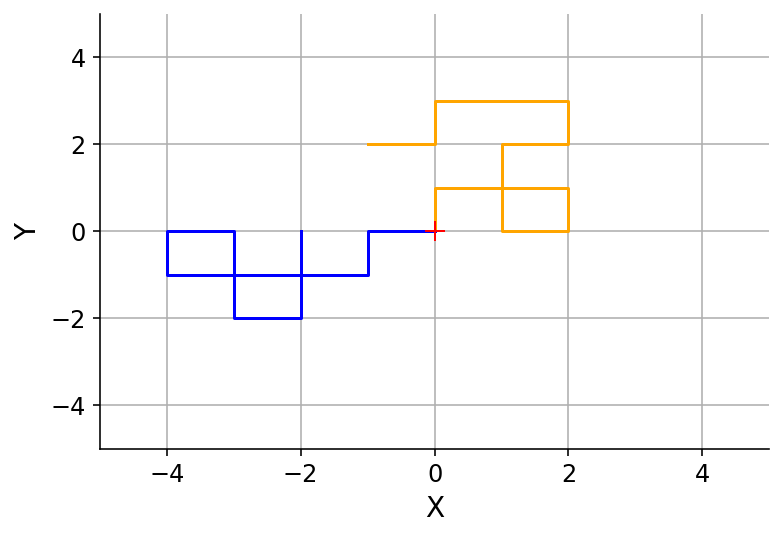

In [19]:
verification_traj= np.array([[0,0],[0,1], [1,1], [2,1], [2,0], [1,0], [1,1], [1,2], [2,2], [2,3], [1,3], [0,3], [0,2], [-1,2]])
verification2_traj= np.array([[0,0],[-1,0], [-1,-1], [-2,-1], [-3,-1], [-4,-1], [-4,0], [-3,0], [-3,-1], [-3,-2], [-2,-2],[-2,-1], [-2,0]])

plt.plot(verification_traj[:,0], verification_traj[:,1],c='orange')
plt.plot(verification2_traj[:,0], verification2_traj[:,1],c='blue')
plt.plot(0, 0, c='red', marker='+',markersize=10)
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.grid()

print("The orange traj has " + str(count_self_intersections(verification_traj))+ " intersection as you can see")
print("The blue traj has " + str(count_self_intersections(verification2_traj))+ " intersection as you can see")

To verify the correct functioning of my count_self_intersecitons function, I decided to proove it on some trajectories that were built on my own. Here I've shown tho simple trajecotries as an example.

## Generating the initial condition
You might have noticed that the pivot algorithm requires an element of SAW($n$) as starting condition, to then generate a Markov chain easily. But how do you get this first element? We will use the following strategy:
1. Generate a standard 2D random walk, and count the number of self intersections.
2. Apply the pivot transformation to get a new 2D random walk, and count the number of self-intersections-
3. If the number of self-intersections has decreased or not changed, keep the new path. Else, keep the old one.
4. Go to 2, till the number of self-intersections is 0.

### Exercise 3.12
Write a function `get_first_SAW` that generates a SAW of given length

In [20]:
import sys, time

def get_first_SAW(length, max_tries):
    print("I'am trying to get a new SAW with %i steps in %i tries of the Pivot's Algorithm" %(length,max_tries))
    time.sleep(0.3)
    traj=get_traj(length)
    for i in tqdm(range(max_tries)):
        value = count_self_intersections(traj)

        new_traj=pivot_traj(traj)
        new_value = count_self_intersections(new_traj)
        if new_value <= value:
            traj = new_traj
        if new_value == 0:
            print("I've found the trajectory!!")
            print('\n')
            print('\n')
            return traj
    if count_self_intersections(traj) != 0:
        print("I could not fine SAW")
        print('\n')
        print('\n')
        return traj
    else:
        return traj

Here is my function to get a first saw. The strategy I adopted is:
1. Get a first random trajectory with the function get_traj() that, given a length, returns a new Random Walk with that given lenghts
2. For max_tries time, I apply the Pivot's Algorithm to the `traj` given by the first step: I call `new_traj` the new trajectory from the Pivot's Algorithm. if the new_traj's number of self intersection is less than the traj's one, `new_traj` became `traj`.
3. After the second step, if `traj` has 0 self intersection, I return that trajectory which is a Self Avoiding Walk. If not i go to step 1.
4. After max_tries attempts, if `traj`'s number self intersection is still different from zero, I return that trajectory telling it is not a SAW.


Next cells are used to show the correct functioning of all the function I implemented.

In [21]:
check = False
while check==False:
    print("I'll execute Pivot's Algorithm until I get a new Saw")
    time.sleep(0.3)
    first_traj=get_first_SAW(100,1000000)
    if count_self_intersections(first_traj) == 0:
        check=True
    time.sleep(1)

I'll execute Pivot's Algorithm until I get a new Saw
I'am trying to get a new SAW with 100 steps in 1000000 tries of the Pivot's Algorithm


  0%|          | 1679/1000000 [00:00<05:35, 2971.28it/s]


I've found the trajectory!!






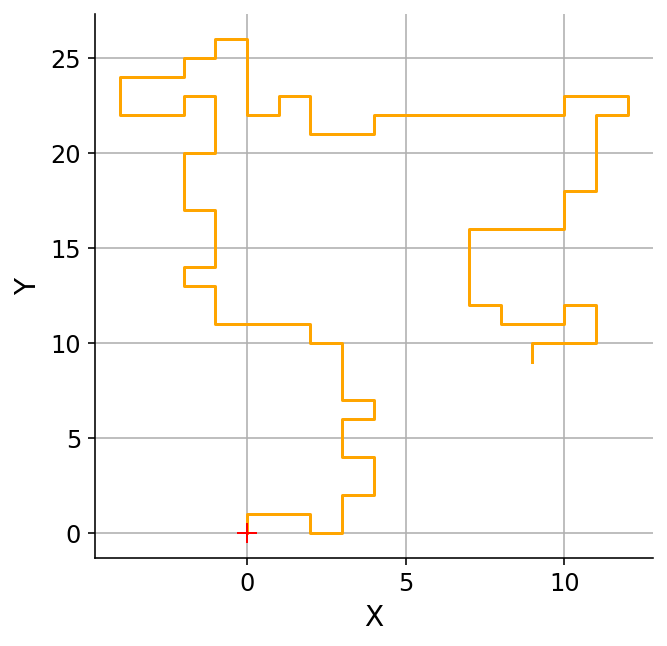

In [22]:
plt.figure(figsize=(5,5))
plt.plot(first_traj[:,0], first_traj[:,1],c='orange')
plt.plot(0, 0, c='red', marker='+',markersize=10)
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()

### Exercise 3.13
Generate and plot some 2D SAWs of different lengths. Be carefull, raise the length slowly! You can measure how long a cell takes executing using the `%%time` magic at the top of a cell.


I decided to use `max_tries`= 10000. To be sure I find a SAW of given length, I used a while cycle and a boolean variable with name `check`. I repeat the attempt of getting a first SAW untill the get_first_SAW function gives a trajectory with 0 self interserction.

In [23]:
lenghts=[10,20,50,100,500,1000]
#lenghts = np.array([ int(x) for x in np.geomspace(10, 100, num=10) ])
res=[]
for leng in lenghts:
    check = False
    while check==False:
        print("I'll execute Pivot's Algorithm until I get a new Saw with length = %i" %(leng))
        time.sleep(0.3)
        first_traj=get_first_SAW(leng,1000000)
        if count_self_intersections(first_traj) == 0:
            check=True
        time.sleep(1)
    res.append(first_traj)

I'll execute Pivot's Algorithm until I get a new Saw with length = 10
I'am trying to get a new SAW with 10 steps in 1000000 tries of the Pivot's Algorithm


  0%|          | 19/1000000 [00:00<04:12, 3956.50it/s]


I've found the trajectory!!




I'll execute Pivot's Algorithm until I get a new Saw with length = 20
I'am trying to get a new SAW with 20 steps in 1000000 tries of the Pivot's Algorithm


  0%|          | 44/1000000 [00:00<04:09, 4014.91it/s]


I've found the trajectory!!




I'll execute Pivot's Algorithm until I get a new Saw with length = 50
I'am trying to get a new SAW with 50 steps in 1000000 tries of the Pivot's Algorithm


  0%|          | 474/1000000 [00:00<03:20, 4982.08it/s]


I've found the trajectory!!




I'll execute Pivot's Algorithm until I get a new Saw with length = 100
I'am trying to get a new SAW with 100 steps in 1000000 tries of the Pivot's Algorithm


  0%|          | 985/1000000 [00:00<05:27, 3048.24it/s]


I've found the trajectory!!




I'll execute Pivot's Algorithm until I get a new Saw with length = 500
I'am trying to get a new SAW with 500 steps in 1000000 tries of the Pivot's Algorithm


  1%|          | 9872/1000000 [00:14<24:12, 681.66it/s]


I've found the trajectory!!




I'll execute Pivot's Algorithm until I get a new Saw with length = 1000
I'am trying to get a new SAW with 1000 steps in 1000000 tries of the Pivot's Algorithm


  3%|▎         | 33408/1000000 [01:39<48:08, 334.61it/s]  


I've found the trajectory!!






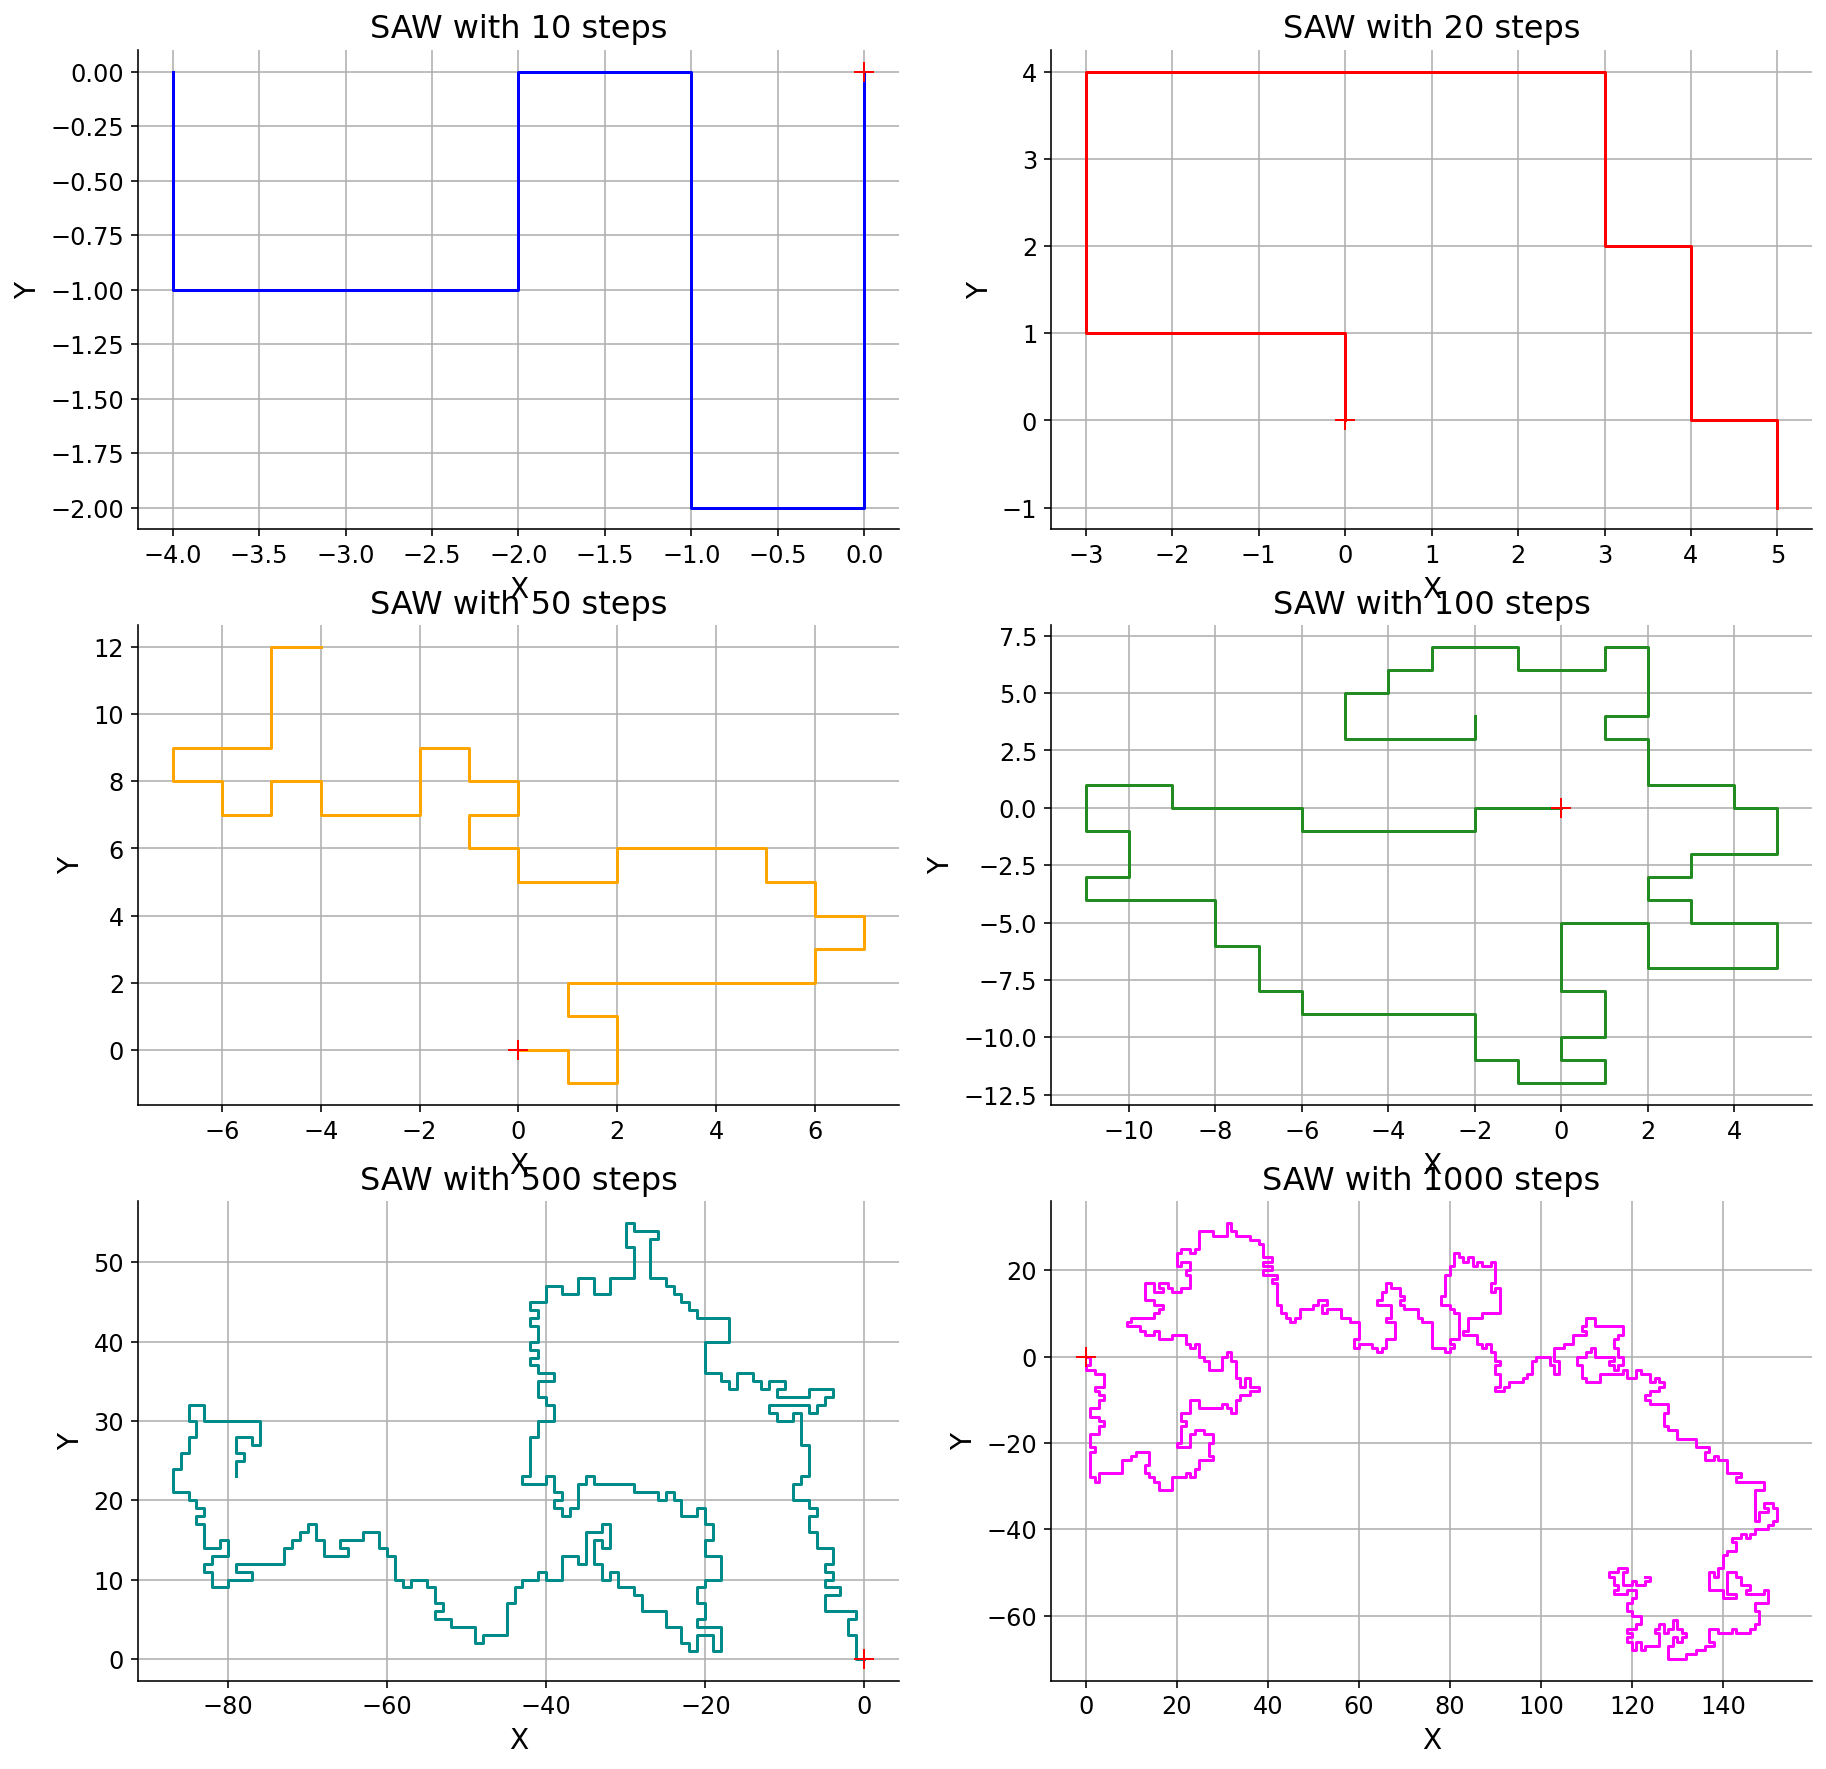

In [24]:
fig, axs = plt.subplots(3,2, figsize=(15, 15))
color=['blue', 'red', 'orange', 'forestgreen', 'darkcyan','magenta']
lenghts=[10,20,50,100,500,1000]

axs = axs.ravel()

for i in range(6):
    axs[i].plot(res[i][:,0],res[i][:,1], c=color[i])
    axs[i].set_title("SAW with %i steps" %(lenghts[i]))
    axs[i].grid()
    axs[i].plot(0, 0, c='red', marker='+',markersize=10)
    axs[i].set_xlabel("X")
    axs[i].set_ylabel("Y")

### Exercise 3.14
Write a function `get_next_SAW` that, given a SAW, generates another SAW using the pivot algorithm. Your function should check that the input RW is really a SAW. Remember the steps:

1. Apply the pivot transformation
2. Check if the new path is self-avoiding. **If so, return it. Otherwise, return the original path.**

In [25]:
def get_next_SAW(traj):
    assert count_self_intersections(traj) == 0

    proposed_traj = pivot_traj(traj)
    num_intersections = count_self_intersections(proposed_traj)
    
    if count_self_intersections(proposed_traj) == 0:
        return proposed_traj
    else:
        return traj

### Mean Squared Displacement in SAW
A quantity of interest in RWs is the mean squared displacement, which is simply the (squared) distance between the endpoints of the walk. Usually, one writes

$$
\left\langle X(n)^2 \right\rangle \sim n^{2 \nu}
$$

As you know, for a standard RW of $n$ steps, the mean-squared displacement scales like $n$, so $\nu=1/2$. However, the exponent for SAW is **different**! Althought it has not been formally proven (still), it is believed that the exponent for SAW is $\nu=3/4$. That is, for a self-avoiding random walk, the mean squared displacement scales as $n^{3/2}$.

### Exercise 3.15
Explain why it makes sense that the mean-squared displacement exponent of SAW is **greater** than that of standard RW. 

It makes totally sense that the mean-squared dispacement exponent of SAW is greater than the standard RW. This is because a SAW cannot overlap itself. This fact "pushes" it away from the points of the plane it has already visited. So it is more difficult for the SAW to come back near a point it has already visited: the probability that a SAW finds a trajectory that allows him to return near the origin is less than the probability that he finds a path with steps away from the origin. This is obvious if you think of a RW and a SAW of lenghts=2. After the first step is impossible for the SAW to come back to the origin, insted the RW has $P=\frac{1}{4}$ to go back to the origin.

This is why SAWs have mean-squared displacement greater that RWs. With equal length, RWs have some trajectories that can come back to points they have already visited. This trajectories owned by RW (but not SAW!) reduce the mean $\left\langle X(n)^2 \right\rangle$: this is the reason why the mean-squared displacement exponent of SAW is greater than RW's one.

### Exercise 3.16
Verify numerically the scaling of the mean-squared displacement of SAW. Notice that you don't need to store all the SAWs, just the endpoints. You could follow this scheme:

1. Generate a first SAW with your `get_first_SAW()` function
2. Generate the next SAW using your `get_next_SAW()` function, and store the endpoint.
3. Iterate step 2 for as many steps as required
4. Compute the average mean-squared displacement of the stored endpoints

Then repeating steps 1-4 for different lengths, and plot the results in double-logarithmic axis. Compare your results with the theoretical exponent. Do they agree?

In [26]:
results=[]
N=10000
for i,leng in enumerate(lenghts):
    temp=0
    for j in range(N):
        new_traj=get_next_SAW(res[i])
        if count_self_intersections(new_traj) == 0:
            res[i]=new_traj
        temp += res[i][-1][0]**2 + res[i][-1][1]**2
    temp /= N
    results.append(temp)

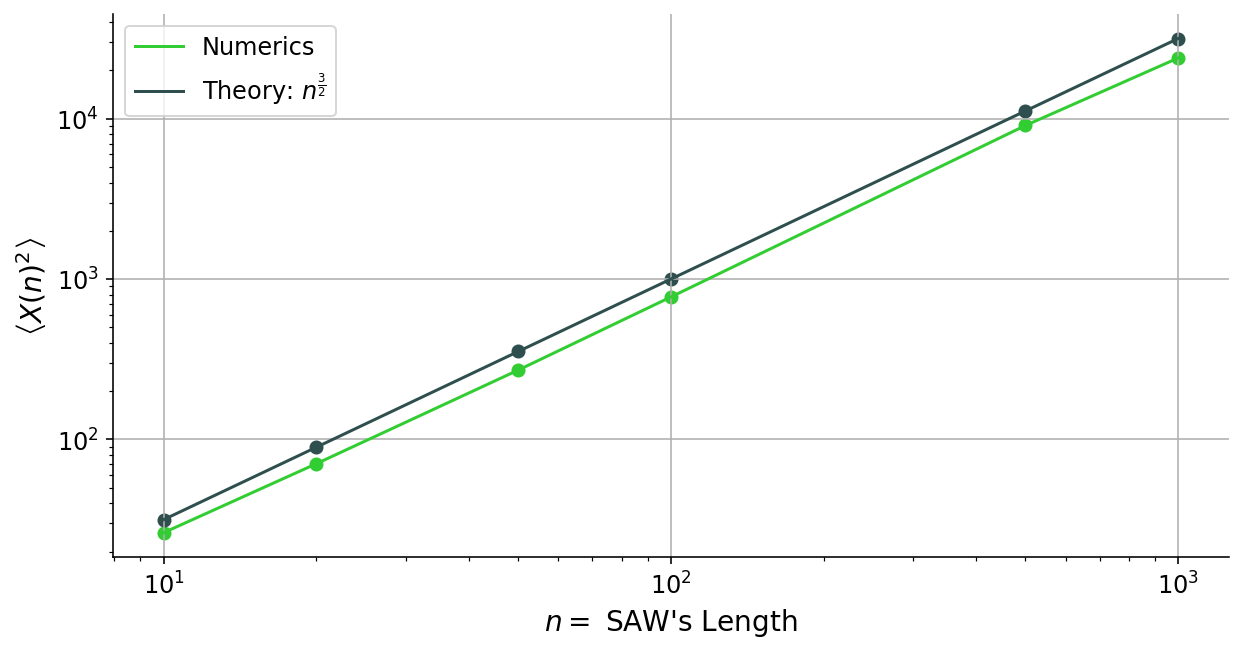

In [27]:
y=[ n**(3/2) for n in lenghts]

plt.figure(figsize=(10,5))
plt.plot(lenghts,results, color='limegreen',label='Numerics')
plt.scatter(lenghts,results, color='limegreen')
plt.plot(lenghts, y, c='darkslategrey', label=r'Theory: $n^{\frac{3}{2}}$')
plt.scatter(lenghts, y, c='darkslategrey')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$n =$ SAW's Length")
plt.ylabel(r'$\left\langle X(n)^2 \right\rangle$')
plt.grid()
plt.legend()
plt.show()

The Numerical results are in perfect agreement with Theory predictions. In fact, getting a straight line in log-log scale with angular coefficient $m=\frac{3}{2}$, prove that mean squared displacement's trend is $n^{\frac{3}{2}}$.